In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTModel
from torch.optim import AdamW
from PIL import Image
import os

# 1. Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dir = "F:/Class/FYP/newdataset/train"
val_dir = "F:/Class/FYP/newdataset/validation"
batch_size = 32

# 2. Dataset Preparation
class ImageDataset(Dataset):
    def __init__(self, root_dir):
        self.transform = transforms.Compose([
            transforms.Resize((384, 384)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []
        
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        return self.transform(image), torch.tensor(self.labels[idx])

# 3. Model Definition
class ViTClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-384')
        self.head = nn.Linear(self.vit.config.hidden_size, num_classes)
        
        # Freeze all layers first
        for param in self.vit.parameters():
            param.requires_grad = False
        
        # Unfreeze the last transformer block
        for param in self.vit.encoder.layer[-1].parameters():
            param.requires_grad = True
        
        # Initialize classifier
        nn.init.normal_(self.head.weight, std=0.02)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)

    def forward(self, x):
        vit_outputs = self.vit(pixel_values=x)
        return self.head(vit_outputs.last_hidden_state[:, 0, :])

# 4. Load Pre-Trained Model for Fine-Tuning
checkpoint = torch.load("vit_model_384.pth")
train_dataset = ImageDataset(train_dir)
val_dataset = ImageDataset(val_dir)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model = ViTClassifier(num_classes=len(train_dataset.classes)).to(device)
model.load_state_dict(checkpoint['model_state'])  # Load previous weights

optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# 5. Training Loop (Fine-Tuning for 20 Epochs)
for epoch in range(20):
    # Training
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    
    print(f"Epoch {epoch+1}, Val Accuracy: {100 * correct / total:.2f}%")

# 6. Save Fine-Tuned Model
torch.save({
    'model_state': model.state_dict(),
    'class_names': train_dataset.classes
}, "vit_model_384_finetuned.pth")

C:\Users\User\AppData\Local\Temp\ipykernel_26412\3633290537.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("vit_model_384.pth")
Some weights of

Epoch 1, Val Accuracy: 82.15%
Epoch 2, Val Accuracy: 86.55%
Epoch 3, Val Accuracy: 89.25%
Epoch 4, Val Accuracy: 90.95%
Epoch 5, Val Accuracy: 92.22%
Epoch 6, Val Accuracy: 93.09%
Epoch 7, Val Accuracy: 93.71%
Epoch 8, Val Accuracy: 94.42%
Epoch 9, Val Accuracy: 94.75%
Epoch 10, Val Accuracy: 94.92%
Epoch 11, Val Accuracy: 95.15%
Epoch 12, Val Accuracy: 95.34%
Epoch 13, Val Accuracy: 95.54%
Epoch 14, Val Accuracy: 95.67%
Epoch 15, Val Accuracy: 95.81%
Epoch 16, Val Accuracy: 95.91%
Epoch 17, Val Accuracy: 96.00%
Epoch 18, Val Accuracy: 96.11%
Epoch 19, Val Accuracy: 96.16%
Epoch 20, Val Accuracy: 96.34%


C:\Users\User\AppData\Local\Temp\ipykernel_26300\777091508.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("vit_model_384_finetuned.pth")  # Loa


Classification Report:
              precision    recall  f1-score   support

     Ascozin     0.9075    0.9325    0.9199       400
      Bioflu     0.9825    0.9800    0.9812       400
    Biogesic     0.9478    0.9525    0.9501       400
    Bonamine     0.9672    0.9575    0.9623       400
    Buscopan     0.9576    0.9600    0.9588       400
     DayZinc     0.9576    0.9600    0.9588       400
    Decolgen     0.9900    0.9875    0.9887       400
      Flanax     0.9603    0.9675    0.9639       400
     Imodium     0.9749    0.9700    0.9724       400
    Lactezin     0.9500    0.9500    0.9500       400
     Lagundi     0.9695    0.9550    0.9622       400
       Midol     0.9719    0.9500    0.9608       400
      Myra_E     0.9950    0.9900    0.9925       400
  Neurogen_E     0.9850    0.9875    0.9863       400
  Omeprazole     0.9530    0.9625    0.9577       400
     Rinityn     0.9249    0.9550    0.9397       400
     Rogin_E     0.9650    0.9650    0.9650       400
   

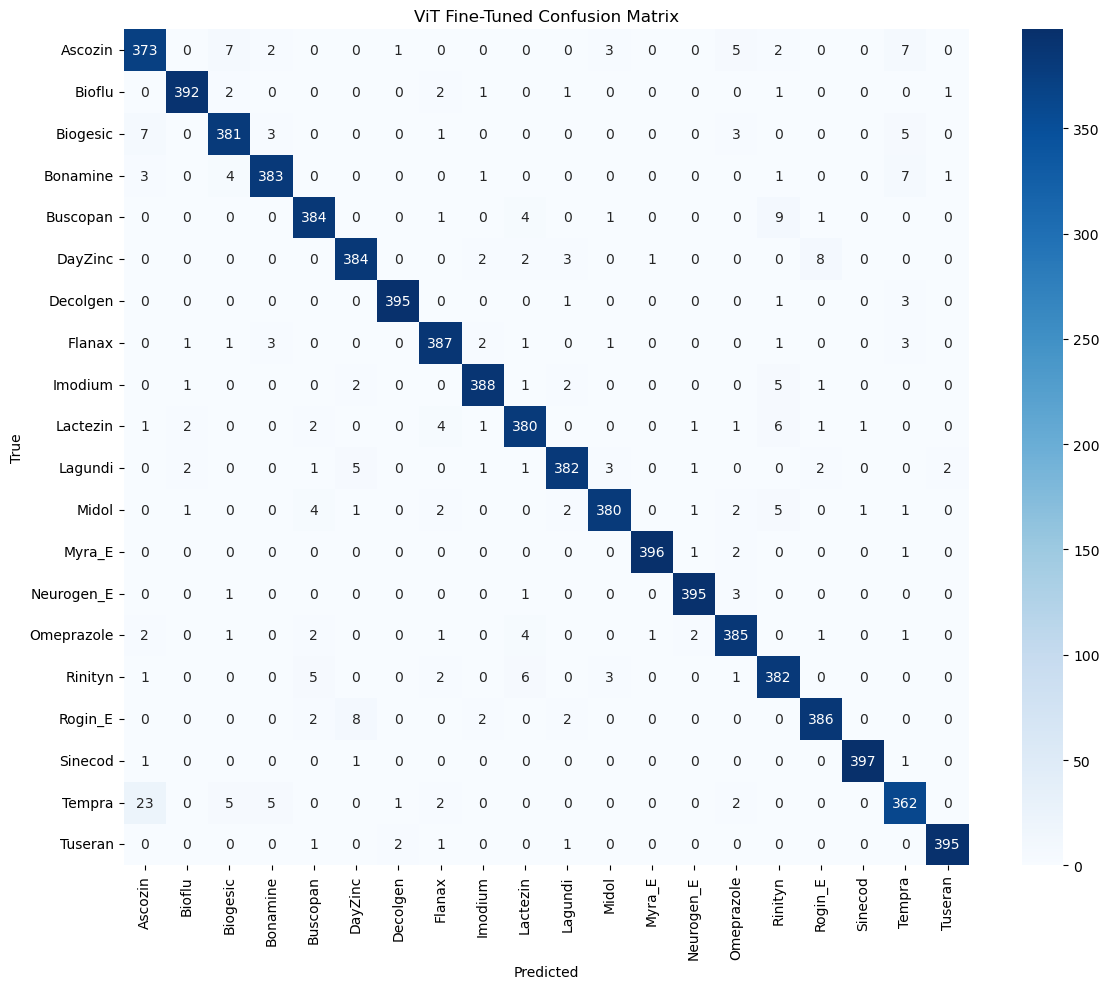


Overall Validation Accuracy: 96.34%

Per-Class Accuracy:
Ascozin: 93.25%
Bioflu: 98.00%
Biogesic: 95.25%
Bonamine: 95.75%
Buscopan: 96.00%
DayZinc: 96.00%
Decolgen: 98.75%
Flanax: 96.75%
Imodium: 97.00%
Lactezin: 95.00%
Lagundi: 95.50%
Midol: 95.00%
Myra_E: 99.00%
Neurogen_E: 98.75%
Omeprazole: 96.25%
Rinityn: 95.50%
Rogin_E: 96.50%
Sinecod: 99.25%
Tempra: 90.50%
Tuseran: 98.75%

Class-wise Precision/Recall:
Ascozin: Precision=0.908, Recall=0.932
Bioflu: Precision=0.982, Recall=0.980
Biogesic: Precision=0.948, Recall=0.953
Bonamine: Precision=0.967, Recall=0.958
Buscopan: Precision=0.958, Recall=0.960
DayZinc: Precision=0.958, Recall=0.960
Decolgen: Precision=0.990, Recall=0.988
Flanax: Precision=0.960, Recall=0.968
Imodium: Precision=0.975, Recall=0.970
Lactezin: Precision=0.950, Recall=0.950
Lagundi: Precision=0.970, Recall=0.955
Midol: Precision=0.972, Recall=0.950
Myra_E: Precision=0.995, Recall=0.990
Neurogen_E: Precision=0.985, Recall=0.988
Omeprazole: Precision=0.953, Recall=0.

In [1]:
import torch
import numpy as np
from torchvision import transforms
from transformers import ViTModel
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

# 1. Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
val_dir = "F:/Class/FYP/newdataset/validation"  # Update your path
batch_size = 32

# 2. Define Model Class (match fine-tuned training configuration)
class ViTClassifier(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-384')
        self.head = torch.nn.Linear(self.vit.config.hidden_size, num_classes)
        
        # Freeze all layers first
        for param in self.vit.parameters():
            param.requires_grad = False
        
        # Unfreeze the last transformer block
        for param in self.vit.encoder.layer[-1].parameters():
            param.requires_grad = True
        
        # Initialize classifier
        torch.nn.init.normal_(self.head.weight, std=0.02)
        if self.head.bias is not None:
            torch.nn.init.zeros_(self.head.bias)

    def forward(self, x):
        vit_outputs = self.vit(pixel_values=x)
        return self.head(vit_outputs.last_hidden_state[:, 0, :])

# 3. Define Dataset Class (match fine-tuned training configuration)
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.transform = transforms.Compose([
            transforms.Resize((384, 384)),  # Model input size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalization values
        ])
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        return self.transform(image), torch.tensor(self.labels[idx])

# 4. Load Fine-Tuned Model
checkpoint = torch.load("vit_model_384_finetuned.pth")  # Load the fine-tuned model checkpoint
model = ViTClassifier(num_classes=len(checkpoint['class_names'])).to(device)
model.load_state_dict(checkpoint['model_state'])
model.eval()

# 5. Prepare Validation Data
val_dataset = ImageDataset(val_dir)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

# 6. Run Evaluation
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 7. Generate Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, 
                           target_names=checkpoint['class_names'], 
                           digits=4))

# 8. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=checkpoint['class_names'],
            yticklabels=checkpoint['class_names'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ViT Fine-Tuned Confusion Matrix')
plt.tight_layout()
plt.savefig('vit_finetuned_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 9. Additional Metrics
accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"\nOverall Validation Accuracy: {accuracy*100:.2f}%")

# Per-class accuracy
class_acc = cm.diagonal() / cm.sum(axis=1)
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(checkpoint['class_names']):
    print(f"{class_name}: {class_acc[i]*100:.2f}%")

# Precision-Recall for each class
print("\nClass-wise Precision/Recall:")
for i, class_name in enumerate(checkpoint['class_names']):
    precision = cm[i,i] / cm[:,i].sum()
    recall = cm[i,i] / cm[i,:].sum()
    print(f"{class_name}: Precision={precision:.3f}, Recall={recall:.3f}")
